In [1]:
# Initial imports

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torchsummary import summary #https://github.com/sksq96/pytorch-summary
torch.manual_seed(1234)
np.random.seed(1234)
from torch.utils.data import Subset

from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

import matplotlib
font = {'size'   : 16}

matplotlib.rc('font', **font)

# Neural network to relate the input spectra to the output physical parameters (temperature and velocity)

### Our goal is fairly simple: train a neural network that matches one spectrum to one set of "nodes" (recall the previous notebook)

### Validate and test the network

### Apply it to real-life data

Possibilities for the network architecture are endless, and, again, you know most of the architectures better than me. What we will do here, is just show the concept and discuss what happens. Later we can make it more fancy



In [25]:
# This is faily simple fully connected, not-so-deep neural network:

# Discuss in moderate detail what each thing does: 


class dnn(nn.Module):
    
    def __init__(self, inputchan, input_wvl, outputsize):
        super(dnn, self).__init__()
        
        inputsize = inputchan * input_wvl
        
        
        self.conv1 = nn.Conv1d(inputchan,4,9,padding=4, padding_mode='replicate')
        self.conv2 = nn.Conv1d(4,4,3,padding=1, padding_mode='replicate')
        
        self.pool = nn.MaxPool1d(2)
        
        self.activationLR = nn.LeakyReLU()
        self.activationS = nn.Sigmoid()
        
        self.linear1 = nn.Linear(inputsize // 4, 16)   
        self.linear2 = nn.Linear(16, outputsize)
        
        self.flat = nn.Flatten()
        
        
    def forward(self, data_in):
        
        x = self.conv1(data_in)
        x = self.activationLR(x)
        x = self.pool(x)
        x = self.pool(x)
        x = self.pool(x)
        
        
        #x = self.conv2(x)
        #x = self.pool(x)
        #x = self.activationLR(x)
        
        x = self.flat(x)
        
        x = self.linear1(x)
        x = self.activationLR(x)
        
        x = self.linear2(x)
        return x
    


In [26]:
def make_model(cudaoption, input_chan, input_wvl, outputsize):
    
    model = dnn(input_chan, input_wvl, outputsize)
    
    if (cudaoption):
        print('[INFO] Cuda model:',torch.cuda.get_device_name(0))
        model = model.to(device)
        
        print('[INFO] Parameters in GPU:',next(model.parameters()).is_cuda) 
        
    return model   

def model_predict(model, inputdata, cudaoption):
    
    if cudaoption:
        
        model = model.to(device)
        inputdata = inputdata.to(device)
        
    output = model.forward(inputdata)
    
    output = output.to("cpu")
    return output

## Let's make a function to train:

def compilefit(model, data_in, data_out, data_val_in, data_val_out, nepochs, criterion, cudaoption, lri, output_interval, batch, weight_decayi):
    
    optimizer = torch.optim.Adam(model.parameters(), lr = lri, weight_decay = weight_decayi)
    loss_fn = nn.MSELoss()
    loss_val_fn = nn.MSELoss()
    
    if cudaoption:
        data_in = data_in.to(device)
        data_out = data_out.to(device)
        data_val_in = data_val_in.to(device)
        data_val_out = data_val_out.to(device)
        
        
    performance = np.zeros([2,nepochs])
                
    for i in range(0,nepochs):
            
        optimizer.zero_grad()
        
        out = model.forward(data_in)
        loss = loss_fn(data_out, out)
        
        loss.backward()
        optimizer.step()
        
        performance[0,i] = loss.item()
        
        # Validation:
        out_val = model.forward(data_val_in)
        loss_val = loss_val_fn(out_val, data_val_out)
        
        performance[1,i] = loss_val.item()
        
            
        if (i+1)%int(output_interval)==0: print(f' It : {i+1:3d} - residual std : {np.sqrt(loss.item()):.6f} - val std : {np.sqrt(loss_val.item()):.6f}')
    return performance

In [27]:
# test for GPU:

cudaoption = torch.cuda.is_available()
device = torch.device("cuda:0" if cudaoption else "cpu")
print('[INFO] Cuda:', cudaoption)
print('[INFO] Cuda device:', device)

[INFO] Cuda: True
[INFO] Cuda device: cuda:0


In [28]:
dnn_model = make_model(cudaoption, 2, 200, 10)

[INFO] Cuda model: NVIDIA RTX A2000 Laptop GPU
[INFO] Parameters in GPU: True


In [29]:
summary(dnn_model,(2,200))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1               [-1, 4, 200]              76
         LeakyReLU-2               [-1, 4, 200]               0
         MaxPool1d-3               [-1, 4, 100]               0
         MaxPool1d-4                [-1, 4, 50]               0
         MaxPool1d-5                [-1, 4, 25]               0
           Flatten-6                  [-1, 100]               0
            Linear-7                   [-1, 16]           1,616
         LeakyReLU-8                   [-1, 16]               0
            Linear-9                   [-1, 10]             170
Total params: 1,862
Trainable params: 1,862
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 0.01
Estimated Total Size (MB): 0.03
-----------------------------------------------

In [30]:
from astropy.io import fits

In [31]:
# Load the input data:

data_in = fits.open("normalized_data_in.fits")[0].data
data_in = data_in.reshape(-1,2,200)
data_in.shape

(3721, 2, 200)

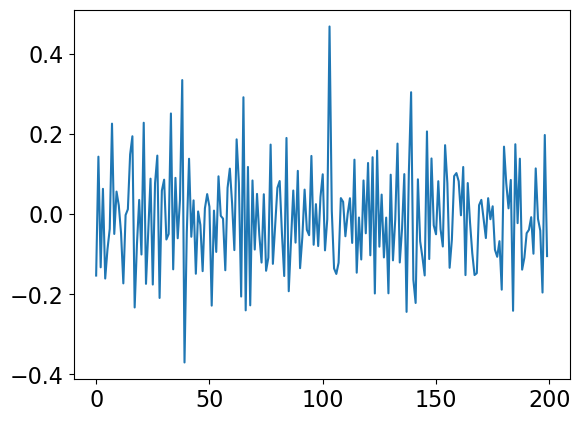

In [32]:
plt.plot(data_in[3125,1])

In [33]:
# We can now see what our network produces (it's still untrained)

In [34]:
data_in = torch.from_numpy(data_in.astype('float32'))


In [35]:
data_in.shape

torch.Size([3721, 2, 200])

torch.Size([10, 10])


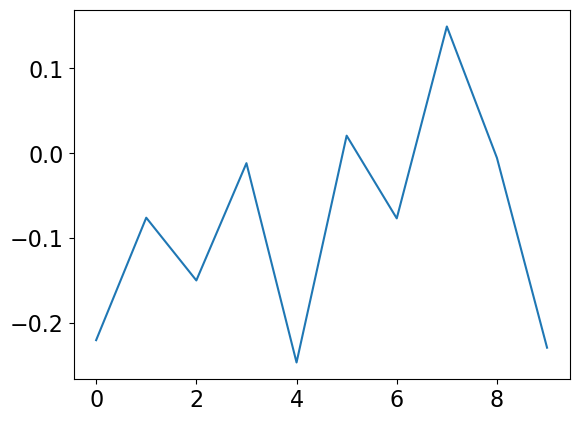

In [36]:
test_output = model_predict(dnn_model,data_in[:10],cudaoption)
print(test_output.shape)
plt.plot(test_output[0].detach().numpy())

### It's something totally random, which should not surprise us as our network is untrained.

### However even if it was, our output is transformed so we would not know if it's correct, we would have to perform some testing. 

In [37]:
data_out = fits.open("normalized_data_out.fits")[0].data
data_out = data_out.transpose(1,2,0)
data_out = data_out.reshape(61*61,10)
print (data_out.shape)
data_out = torch.from_numpy(data_out.astype("float32"))

(3721, 10)


In [38]:
# If you want to use already pre-trained model, do:

#dnn_model = torch.load("inv_full_take_1.pt",map_location=torch.device('cpu'))

In [40]:
# We can now try training: 
# Discuss a bit each of the input values to this function:

convergence = compilefit(dnn_model, data_in, data_out, data_in, data_out, \
                         500000, 0, cudaoption, 5E-3, 1000, 128, 0)

 It : 1000 - residual std : 0.314661 - val std : 0.314647
 It : 2000 - residual std : 0.322303 - val std : 0.324499
 It : 3000 - residual std : 0.312105 - val std : 0.312689
 It : 4000 - residual std : 0.307722 - val std : 0.307729
 It : 5000 - residual std : 0.310002 - val std : 0.311011
 It : 6000 - residual std : 0.315732 - val std : 0.318435
 It : 7000 - residual std : 0.308310 - val std : 0.308448
 It : 8000 - residual std : 0.340842 - val std : 0.351321
 It : 9000 - residual std : 0.304055 - val std : 0.304696
 It : 10000 - residual std : 0.319230 - val std : 0.307798
 It : 11000 - residual std : 0.304932 - val std : 0.302627
 It : 12000 - residual std : 0.337209 - val std : 0.349387
 It : 13000 - residual std : 0.303989 - val std : 0.301129
 It : 14000 - residual std : 0.299978 - val std : 0.301866
 It : 15000 - residual std : 0.301020 - val std : 0.300967
 It : 16000 - residual std : 0.312576 - val std : 0.309372
 It : 17000 - residual std : 0.297938 - val std : 0.297862
 It : 

 It : 140000 - residual std : 0.259697 - val std : 0.260488
 It : 141000 - residual std : 0.259568 - val std : 0.260815
 It : 142000 - residual std : 0.264667 - val std : 0.265862
 It : 143000 - residual std : 0.259518 - val std : 0.261441
 It : 144000 - residual std : 0.266735 - val std : 0.266734
 It : 145000 - residual std : 0.260071 - val std : 0.260607
 It : 146000 - residual std : 0.259672 - val std : 0.262268
 It : 147000 - residual std : 0.275441 - val std : 0.264258
 It : 148000 - residual std : 0.275639 - val std : 0.272818
 It : 149000 - residual std : 0.259059 - val std : 0.258717
 It : 150000 - residual std : 0.259757 - val std : 0.260869
 It : 151000 - residual std : 0.279412 - val std : 0.273972
 It : 152000 - residual std : 0.259961 - val std : 0.259871
 It : 153000 - residual std : 0.264420 - val std : 0.264409
 It : 154000 - residual std : 0.309437 - val std : 0.299129
 It : 155000 - residual std : 0.260930 - val std : 0.261183
 It : 156000 - residual std : 0.260082 -

 It : 277000 - residual std : 0.257885 - val std : 0.258063
 It : 278000 - residual std : 0.292284 - val std : 0.296528
 It : 279000 - residual std : 0.255615 - val std : 0.263733
 It : 280000 - residual std : 0.250518 - val std : 0.250579
 It : 281000 - residual std : 0.257518 - val std : 0.257524
 It : 282000 - residual std : 0.251154 - val std : 0.251577
 It : 283000 - residual std : 0.258122 - val std : 0.258613
 It : 284000 - residual std : 0.251155 - val std : 0.251468
 It : 285000 - residual std : 0.252305 - val std : 0.252895
 It : 286000 - residual std : 0.264732 - val std : 0.267175
 It : 287000 - residual std : 0.254189 - val std : 0.256519
 It : 288000 - residual std : 0.250244 - val std : 0.250714
 It : 289000 - residual std : 0.250613 - val std : 0.250203
 It : 290000 - residual std : 0.249990 - val std : 0.249968
 It : 291000 - residual std : 0.267228 - val std : 0.264532
 It : 292000 - residual std : 0.257782 - val std : 0.254633
 It : 293000 - residual std : 0.259939 -

 It : 414000 - residual std : 0.252304 - val std : 0.253393
 It : 415000 - residual std : 0.248681 - val std : 0.247527
 It : 416000 - residual std : 0.261018 - val std : 0.264675
 It : 417000 - residual std : 0.245862 - val std : 0.245752
 It : 418000 - residual std : 0.249988 - val std : 0.251174
 It : 419000 - residual std : 0.245005 - val std : 0.245000
 It : 420000 - residual std : 0.264779 - val std : 0.262198
 It : 421000 - residual std : 0.247829 - val std : 0.247524
 It : 422000 - residual std : 0.246232 - val std : 0.245794
 It : 423000 - residual std : 0.245398 - val std : 0.245468
 It : 424000 - residual std : 0.244843 - val std : 0.244787
 It : 425000 - residual std : 0.256687 - val std : 0.258239
 It : 426000 - residual std : 0.254429 - val std : 0.255413
 It : 427000 - residual std : 0.246729 - val std : 0.247025
 It : 428000 - residual std : 0.252956 - val std : 0.255123
 It : 429000 - residual std : 0.245093 - val std : 0.245358
 It : 430000 - residual std : 0.245739 -

In [17]:
torch.save(dnn_model, 'inv_full_mihi.pt')

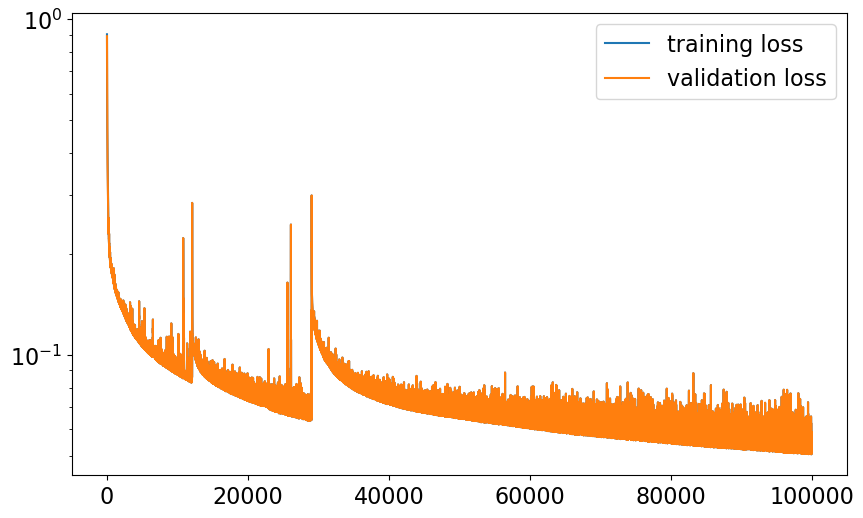

In [18]:
plt.figure(figsize=[10,6])
plt.semilogy(convergence[0],label='training loss') 
plt.semilogy(convergence[1], label = 'validation loss') 
plt.legend()

### Easiest way to test this is to simply apply it to the whole data set and see what comes out :-)

In [19]:
test_output = model_predict(dnn_model,data_in,cudaoption)

In [20]:
test_output = test_output.detach().numpy()

In [21]:
test_output.shape

(3721, 10)

In [22]:
test_output_n = test_output.reshape(61,61,10)
data_out_n = data_out.detach().numpy().reshape(61,61,10)

### How do we do this? 

- We will plot the maps of the original and inferred parameters side by side, as well as scatter plots between the two.

- We will calculate the correlation and the mean difference (stay, std deviation of the difference) between the parameters and compare 

- Note that this is in the "normalized" form, when we transform back it will likely be different

In [23]:
from scipy.stats import pearsonr

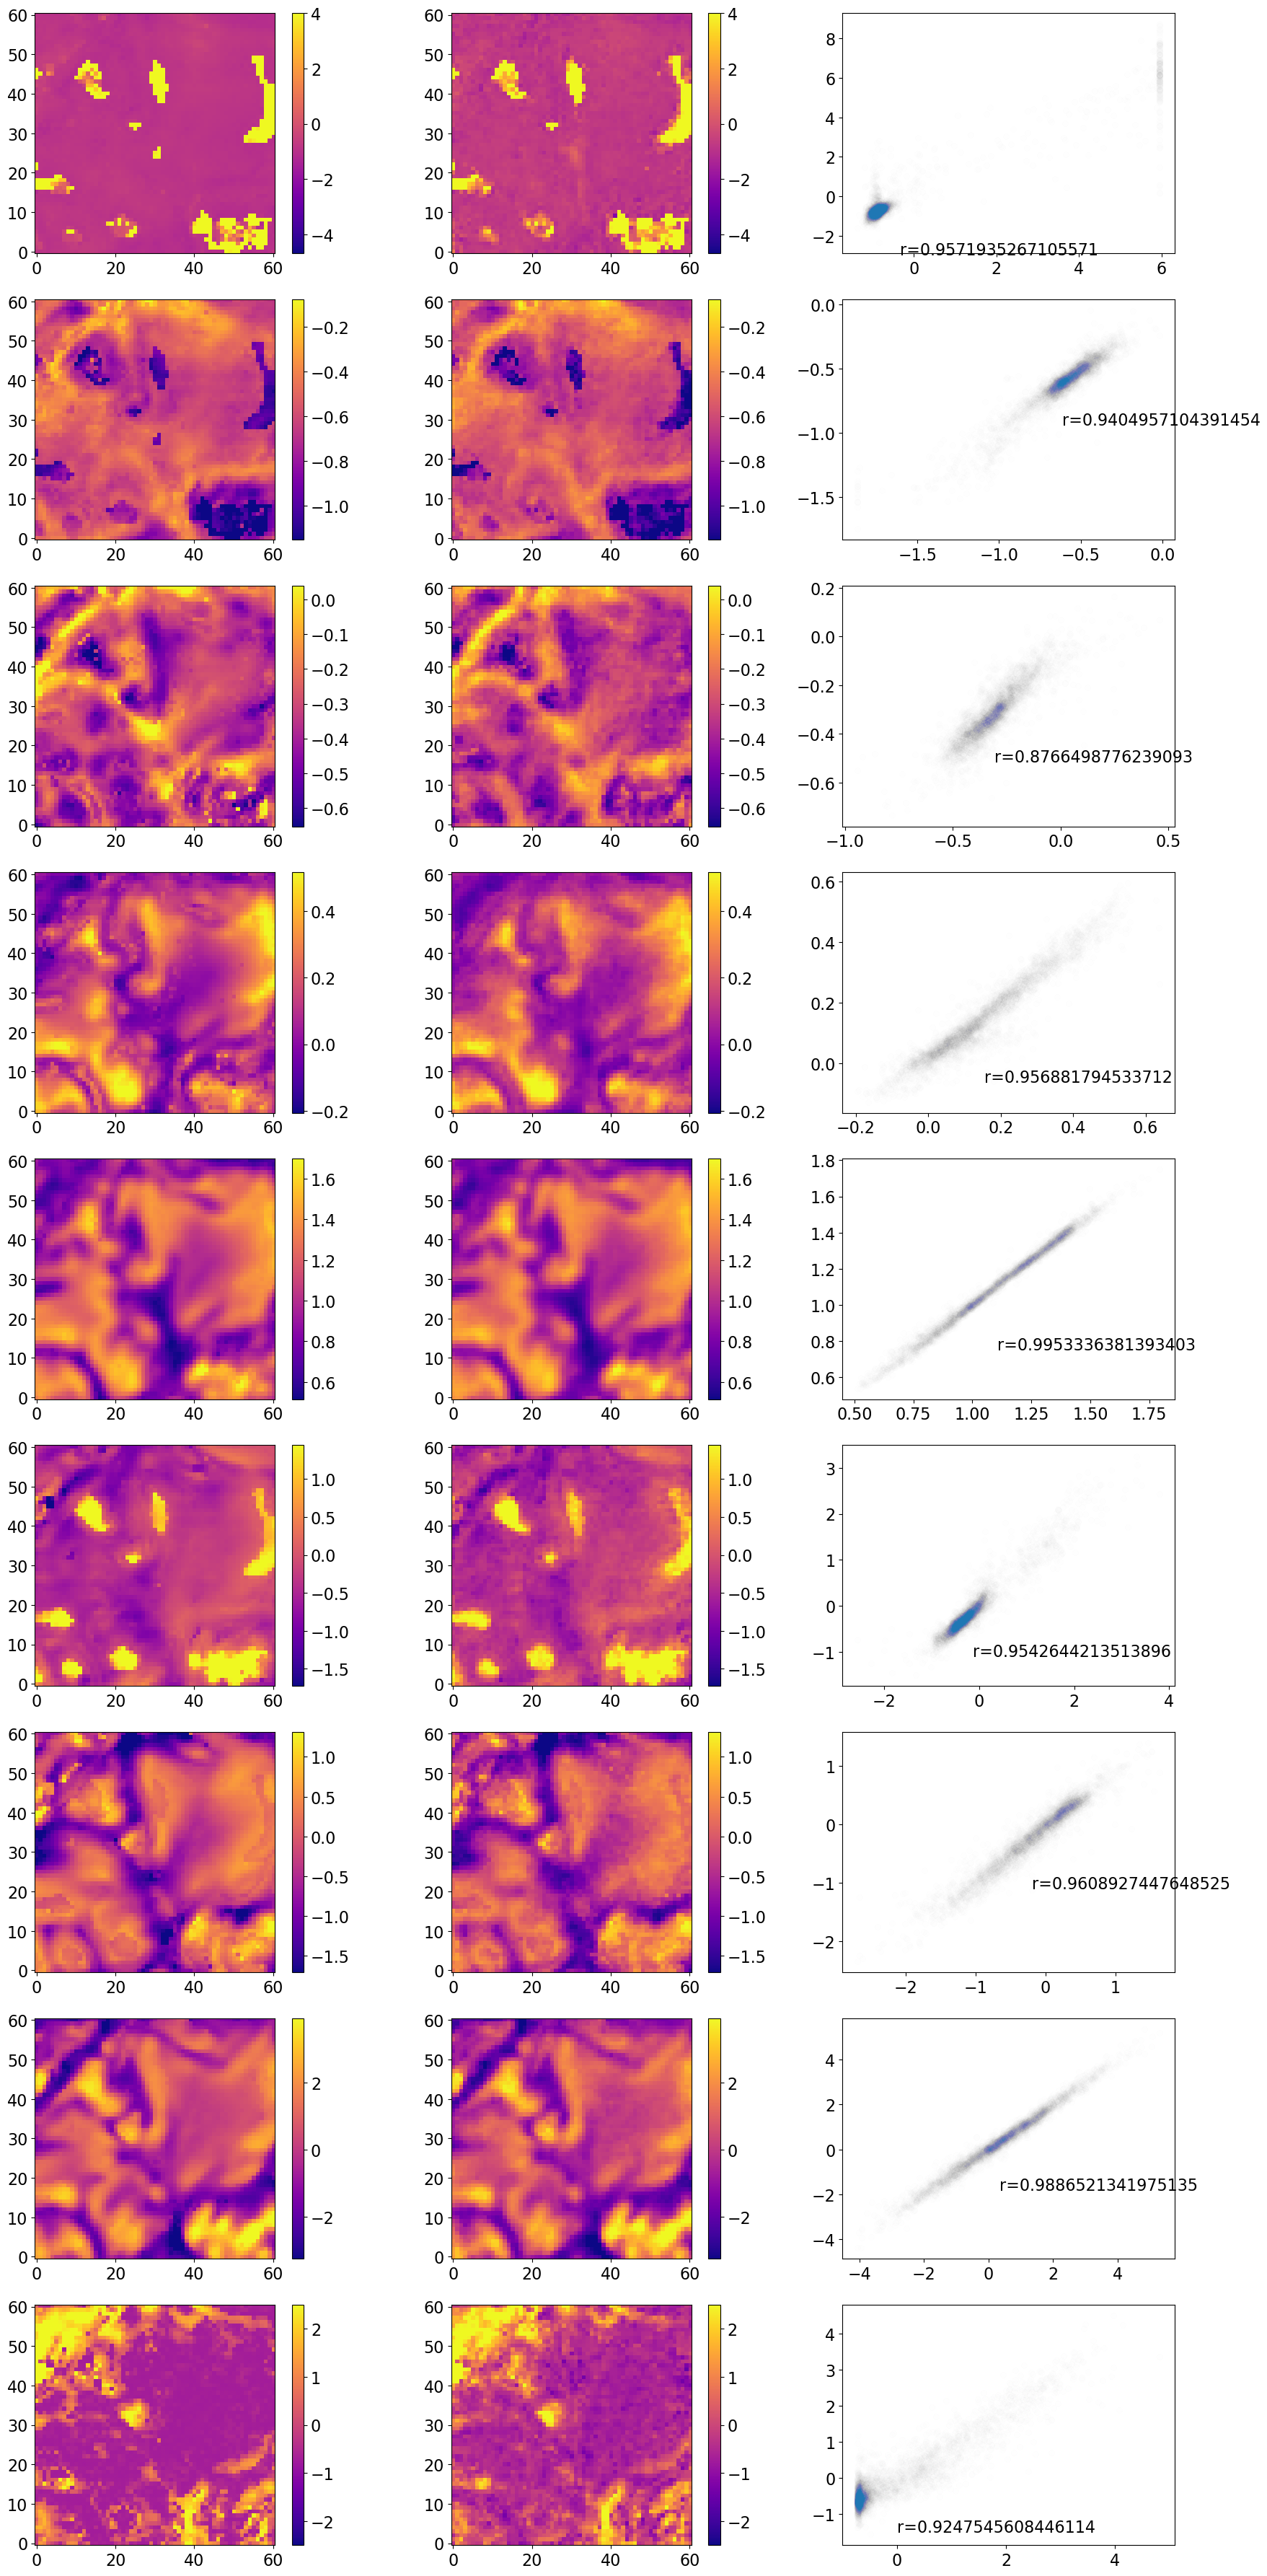

In [24]:
plt.figure(figsize=[18,36])

# First the temperature
NP = 9
for i in range(0,NP):

    m = np.mean(data_out_n[:,:,i])
    s = np.std(data_out_n[:,:,i])
    
    r = pearsonr(data_out_n[:,:,i].flatten(), test_output_n[:,:,i].flatten())
    
    plt.subplot(NP,3,3*i+1)
    plt.imshow(data_out_n[:,:,i].T, origin='lower', cmap='plasma',vmin=m-2.5*s,vmax=m+2.5*s)
    plt.colorbar()
    plt.subplot(NP,3,3*i+2)
    plt.imshow(test_output_n[:,:,i].T, origin='lower', cmap='plasma',vmin=m-2.5*s,vmax=m+2.5*s)
    plt.colorbar()
    plt.subplot(NP,3,3*i+3)
    plt.plot(data_out_n[:,:,i].flatten(),test_output_n[:,:,i].flatten(),'o',alpha=0.002)
    plt.text(m,m-1.5*s,'r='+str(r[0]))
    
plt.tight_layout()



### Can you think of the reasons why the correlation is worse in the upper layers than in the lower ones? What could be happening? 

#### Discuss for a while, go back to the slides if needed

## Same for the velocity:

### Now discuss this one for a little while... 

#### 15 mins to discuss what can be done better, what is going on here, etc. 

#### Maybe talk about the response functions and the ways how we can 'mimic' them via the network? 